In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

#### Carga de los datasets

In [57]:
noaa = pd.read_csv('data/GeoDataFrame/dataframe/df_mar.csv')
iucn_noaa_geo = gpd.read_file('data/processed/iucn_noaa.gpkg') # Obtenido del notebook crear_dataset.ipynb
iucn_noaa_csv =pd.read_csv('data/processed/iucn_noaa_juntos.csv')
ecotaxa = pd.read_csv('data/ecotaxa/metadata_img.csv')
tomex = pd.read_csv('data/processed/species_raw_processed.csv')

/tmp/ipykernel_11870/835687704.py:4: DtypeWarning: Columns (102,139) have mixed types. Specify dtype option on import or set low_memory=False.
  ecotaxa = pd.read_csv('data/ecotaxa/metadata_img.csv')


In [58]:
pd.set_option("display.max_columns", None)

# Grilla espacial y agregación de datos

Este notebook tiene como objetivo construir una grilla espacial regular
y agregar a nivel de celda la información procedente de los datasets
integrados previamente.

La grilla resultante se utilizará como base para los análisis posteriores
y el modelado.

## Dataset base de la grilla

La grilla espacial se construye a partir del dataset integrado
iucn_noaa_geo, que contiene la información geográfica principal
del estudio.

In [60]:
iucn_noaa_geo

,sci_name,redlistCategory,iucn_id,vuln,index_right,mp_pieces_m3,dist_m,geometry
0,Hubbsina turneri,CR,0,4,13104,2115.655853,244627.454273,POINT (-11296646.266 2258169.64)
1,Hubbsina turneri,CR,1,4,13104,2115.655853,237016.489842,POINT (-11329797.21 2252382.257)
2,Hubbsina turneri,CR,2,4,13104,2115.655853,237235.709534,POINT (-11330943.801 2252583.424)
3,Ictalurus mexicanus,VU,3,2,13032,2820.874471,176956.192726,POINT (-11060055.613 2509223.803)
4,Ictalurus mexicanus,VU,4,2,13032,2820.874471,170585.675721,POINT (-11054025.436 2511525.235)
...,...,...,...,...,...,...,...,...
70268,Macrobrachium thysi,VU,70268,2,11468,0.038661,959001.335033,POINT (-334164.413 573406.106)
70269,Macrobrachium thysi,VU,70269,2,11468,0.038661,929073.410690,POINT (-391958.153 613149.338)
70270,Macrobrachium thysi,VU,70270,2,11468,0.038661,929269.937379,POINT (-391057.579 612084.684)
70271,Macrobrachium thysi,VU,70271,2,11468,0.038661,866968.071829,POINT (-458950.223 602254.212)


In [61]:
# Comprobar proyección de lo 
iucn_noaa_geo.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

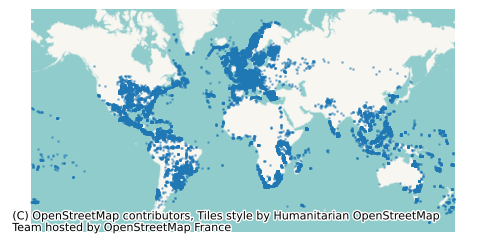

In [62]:
import contextily as ctx

fig, ax = plt.subplots(figsize=(6, 6))
iucn_noaa_geo.plot(ax=ax, markersize=1, alpha=0.4)

ctx.add_basemap(ax)
ax.set_axis_off()

plt.show()

Dado que la distribución de los datos base es global, los datos serán reproyectados a un sistema de referencia global equivalente en área (EPSG:6933), con el fin de garantizar la comparabilidad espacial en la construcción de la grilla.

In [63]:
# Reproyección 
iucn_noaa_geo = iucn_noaa_geo.to_crs(epsg=6933)

In [64]:
# Extracción de coordenadas
iucn_noaa_geo["x"] = iucn_noaa_geo.geometry.x
iucn_noaa_geo["y"] = iucn_noaa_geo.geometry.y

In [65]:
# Validaciones
iucn_noaa_geo[["x", "y"]].describe()

,x,y
count,7.027300e+04,7.027300e+04
mean,-4.543765e+05,3.668438e+06
std,5.995890e+06,2.951223e+06
min,-1.736327e+07,-6.033533e+06
25%,-5.846683e+06,1.728022e+06
50%,-3.544906e+04,5.132305e+06
75%,9.214440e+05,5.731835e+06
max,1.732218e+07,6.977287e+06


In [66]:
# Validaciones
iucn_noaa_geo.isnull().sum().sort_values(ascending=False).head(10)

sci_name           0
redlistCategory    0
iucn_id            0
vuln               0
index_right        0
mp_pieces_m3       0
dist_m             0
geometry           0
x                  0
y                  0
dtype: int64

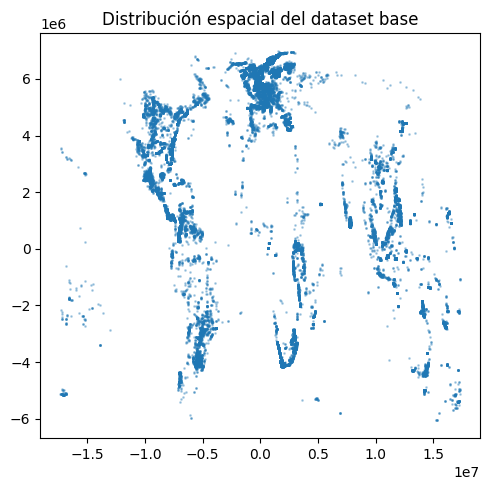

In [67]:
# Confirmación de la distribución de los datos
plt.figure(figsize=(5,5))
plt.scatter(
    iucn_noaa_geo["x"],
    iucn_noaa_geo["y"],
    s=1,
    alpha=0.3
)
plt.title("Distribución espacial del dataset base")
plt.tight_layout()
plt.show()


In [68]:
# Mirar límites de distribución y integración de estos
iucn_noaa_geo.total_bounds
xmin, ymin, xmax, ymax = iucn_noaa_geo.total_bounds
xmin, ymin, xmax, ymax

(np.float64(-17363265.75157428),
 np.float64(-6033533.077570007),
 np.float64(17322181.79695717),
 np.float64(6977287.316660903))

La extensión espacial del dataset base confirma su cobertura global,
con coordenadas expresadas en metros tras la reproyección a EPSG:6933,
lo que permite la construcción de una grilla regular con unidades
espaciales comparables.


## Creación de la grilla

In [69]:
# Definir tamaño de celda (Ajustado a escala global)
cell_size = 100_000  # 100 km (prueba por distancia robusta)

In [70]:
# Generar ejes de la grilla
x_coords = np.arange(xmin, xmax + cell_size, cell_size)
y_coords = np.arange(ymin, ymax + cell_size, cell_size)

len(x_coords), len(y_coords)

(348, 132)

In [71]:
# Construir polígonos de la grilla
from shapely.geometry import box

grid_cells = []

for x in x_coords[:-1]:
    for y in y_coords[:-1]:
        grid_cells.append(
            box(x, y, x + cell_size, y + cell_size)
        )


Cada box es una celda cuadrada de 100×100 km.

In [72]:
# Crear el GeoDataFrame de la grilla
grid = gpd.GeoDataFrame(
    {"geometry": grid_cells},
    crs=iucn_noaa_geo.crs
)

grid["cell_id"] = np.arange(len(grid))
grid.head()

,geometry,cell_id
0,"POLYGON ((-17263265.752 -6033533.078, -1726326...",0
1,"POLYGON ((-17263265.752 -5933533.078, -1726326...",1
2,"POLYGON ((-17263265.752 -5833533.078, -1726326...",2
3,"POLYGON ((-17263265.752 -5733533.078, -1726326...",3
4,"POLYGON ((-17263265.752 -5633533.078, -1726326...",4


In [73]:
# Validación grilla (Número de celdas)
len(grid)

45457

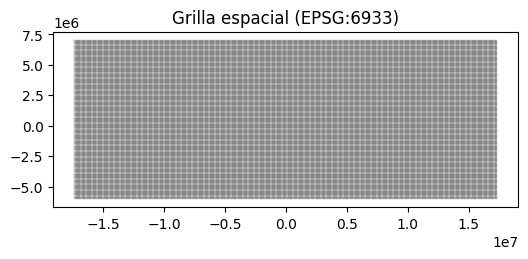

In [74]:
# Validación visual grilla
ax = grid.plot(
    figsize=(6,4),
    facecolor="none",
    edgecolor="black",
    linewidth=0.1
)
plt.title("Grilla espacial (EPSG:6933)")
plt.show()

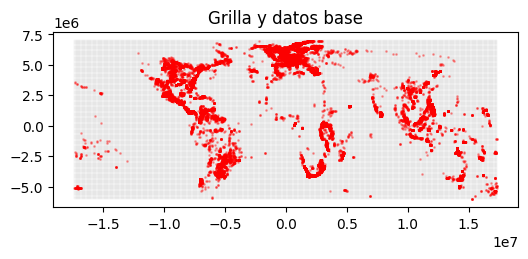

In [75]:
# Validación grilla con datos base
ax = grid.plot(
    figsize=(6,4),
    facecolor="none",
    edgecolor="lightgrey",
    linewidth=0.1
)

iucn_noaa_geo.plot(
    ax=ax,
    markersize=1,
    color="red",
    alpha=0.3
)

plt.title("Grilla y datos base")
plt.show()


La inspección visual de la grilla confirma una discretización regular del espacio de estudio, definida en un sistema de referencia equivalente en área y alineada con la extensión real de los datos.

##### Construcción de la grilla espacial

La grilla se construyó como una malla regular de celdas cuadradas
de 100 km × 100 km, definida en el sistema de referencia EPSG:6933.
Cada celda dispone de un identificador único que permite la agregación
posterior de las variables espaciales.


## Asignación de los datos a la grilla

In [76]:
# Asegurar que CRS coincide
grid.crs == iucn_noaa_geo.crs

True

In [77]:
# Limpieza defensiva antes del spatial join
iucn_noaa_geo = iucn_noaa_geo.reset_index(drop=True)
grid = grid.reset_index(drop=True)

# Por si existe de joins previos
for col in ["index_left", "index_right"]:
    if col in iucn_noaa_geo.columns:
        iucn_noaa_geo = iucn_noaa_geo.drop(columns=col)
    if col in grid.columns:
        grid = grid.drop(columns=col)

In [78]:
# Spatial join: puntos → celdas
points_in_grid = gpd.sjoin(
    iucn_noaa_geo,
    grid,
    how="left",
    predicate="intersects"
)

In [79]:
# Validación (¿Todos los puntos tienen celda?)
points_in_grid["cell_id"].isnull().sum()

np.int64(0)

In [80]:
# Validación (Número de puntos por celda)
points_in_grid["cell_id"].value_counts().describe()

count    3164.000000
mean       22.210177
std       153.937616
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max      5432.000000
Name: count, dtype: float64

In [81]:
# Tabla resumen (Celdas ocupadas vs vacías)
cells_with_data = points_in_grid["cell_id"].nunique()
total_cells = grid["cell_id"].nunique()

cells_with_data, total_cells

(3164, 45457)

In [82]:
# Proporción
cells_with_data / total_cells

0.06960424137096596

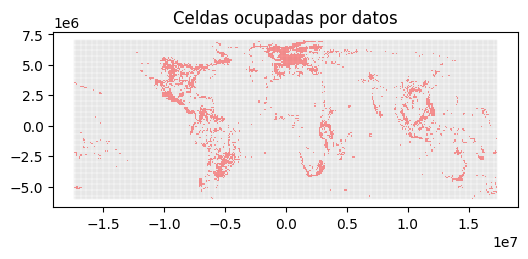

In [83]:
# Visualización
occupied_cells = grid.merge(
    points_in_grid[["cell_id"]].drop_duplicates(),
    on="cell_id",
    how="inner"
)

ax = grid.plot(
    figsize=(6,4),
    facecolor="none",
    edgecolor="lightgrey",
    linewidth=0.1
)

occupied_cells.plot(
    ax=ax,
    color="red",
    alpha=0.4
)

plt.title("Celdas ocupadas por datos")
plt.show()

##### Asignación de datos a la grilla

Cada observación del dataset base fue asignada a una celda de la grilla
mediante una operación de intersección espacial punto–polígono.
El identificador de celda permite agregar posteriormente la información
a nivel espacial.
